# Visualize the results

In [80]:
import numpy as np 
from matplotlib import pyplot as plt

results_folder = './result/'
settings = ['beta1/', 'beta10/', 'beta100/', 'absolute_diff/', 'new_loss/', 
            'new_CNN/', 'loss_CNN/', 'deep_CNN/', 'deep_CNN_iter300/', 'deep_CNN_batch20/',
            'deep_CNN_iter30000/', 'deep_deeper/']

def plot_graph(t, x, y, label, y_dot=None, label_dot=None, subset = [0, 1]): # Here y and label is a list, plot from start(0) to end(1) by default
    plt.figure(figsize=(8,5))
    start_idx = int(len(x)*subset[0])
    end_idx = int(len(x)*subset[1])
    for i in range(len(label)):
        plt.plot(x[start_idx:end_idx], y[i][start_idx:end_idx], label=label[i])
    if not((y_dot is None) and (label_dot is None)):
        for i in range(len(label_dot)):
            plt.plot(x[start_idx:end_idx], y_dot[i][start_idx:end_idx], label=label_dot[i], linestyle=':')
    plt.legend(bbox_to_anchor=(0.7, 0.98), loc=2, borderaxespad=0.)
    plt.title(t, fontsize=20)
    plt.show()

## Evaluating Loss

In [69]:
select = 7
def read_loss(select):
    data = np.load(results_folder + settings[select] + 'loss.npz')
    train = data['train']
    test = data['test']
    return (train[1:,0], train[1:,1], train[1:,2], train[1:,3], test[1:,1], test[1:,2], test[1:,3])

iterations, loss, loss_x, loss_q, losst, losst_x, losst_q = read_loss(select)

### Over all Loss

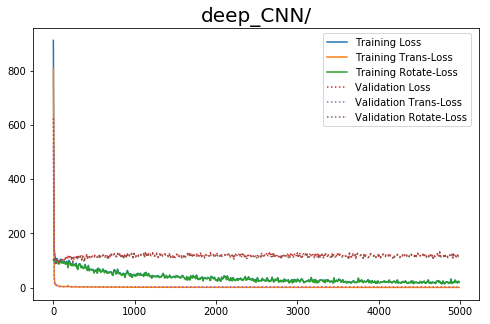

In [70]:
plot_graph(settings[select], iterations, [loss, loss_x, loss_q], ['Training Loss', 'Training Trans-Loss', 'Training Rotate-Loss'],
          y_dot = [losst, losst_x, losst_q], label_dot = ['Validation Loss', 'Validation Trans-Loss', 'Validation Rotate-Loss'])

### Loss for first 20 Iterations

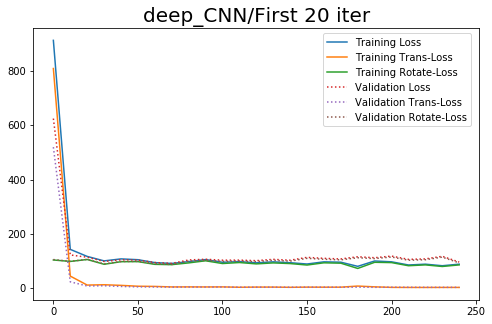

In [73]:
plot_graph(settings[select] + 'First 20 iter', iterations, [loss, loss_x, loss_q], ['Training Loss', 'Training Trans-Loss', 'Training Rotate-Loss'],
          y_dot = [losst, losst_x, losst_q], label_dot = ['Validation Loss', 'Validation Trans-Loss', 'Validation Rotate-Loss'], 
           subset=[0,0.05])

### Loss after 400 Iterations

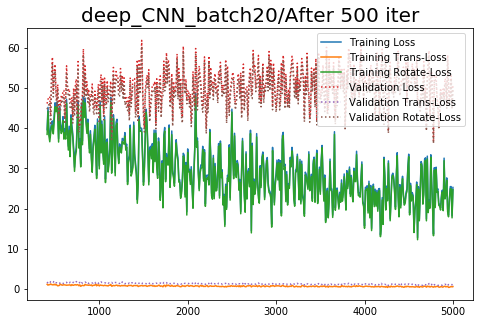

In [68]:
plot_graph(settings[select] + 'After 500 iter', iterations, [loss, loss_x, loss_q], ['Training Loss', 'Training Trans-Loss', 'Training Rotate-Loss'],
          y_dot = [losst, losst_x, losst_q], label_dot = ['Validation Loss', 'Validation Trans-Loss', 'Validation Rotate-Loss'], 
           subset=[0.08, 1])

# Evaluation on test results

In [89]:
import math

settings = ['beta1/', 'beta10/', 'beta100/', 'absolute_diff/', 'new_loss/', 
            'new_CNN/', 'loss_CNN/', 'deep_CNN/', 'deep_CNN_iter300/', 'deep_CNN_batch20/',
            'deep_CNN_iter30000/', 'deep_deeper/']
setting_selector = [4,7,8,9,10,11] #,3,4,5,6,7,8,9,10,11]

def read_prediction(select):
    test = np.load(results_folder + settings[select] + 'prediction.npy')
    return (test[:, :1], test[:,1:4], test[:,8:11], test[:,4:8], test[:,11:]) # x_ground, x_pre, q_ground, q_pre

def cumulative(x, bins):
    values, base = np.histogram(x, bins=bins) # evaluate the histogram
    return (base, np.cumsum(values)) #evaluate the cumulative

def single_loss(x1, x2):
    return np.sqrt(np.sum(np.square(x1 - x2), axis=1))

def batch_loss(x1, x2, num_train_batch, num_test_samples):
    ratio = num_train_batch/num_test_samples
    return np.mean(single_loss(x1, x2))*ratio


### Read data (with all parameter settings)

In [90]:
x_ground = [] 
x_pre = [] 
q_ground = [] 
q_pre = []
cate = []
for i in range(len(setting_selector)):
    ca, xg, xp, qg, qp = read_prediction(setting_selector[i])
    x_ground.append(xg)
    q_ground.append(qg)
    x_pre.append(xp)
    q_pre.append(qp)
    cate.append(ca)

### evaluate rotation error

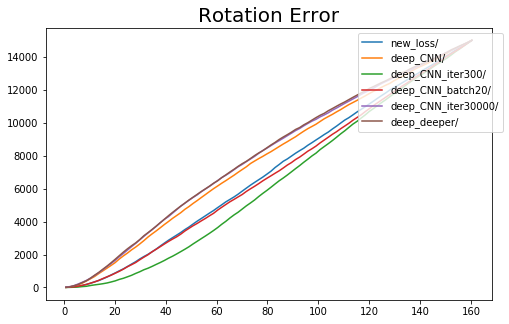

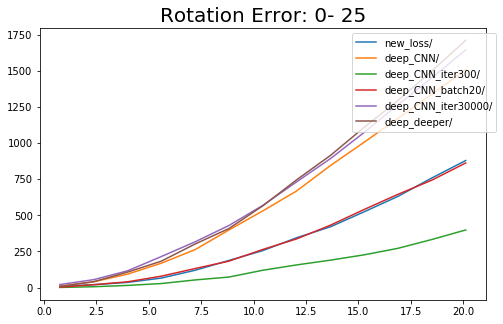

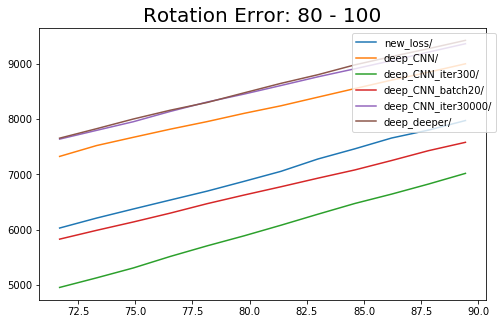

In [91]:
def quat_norm(q):
    return q/np.linalg.norm(q, axis=1)[np.newaxis,:].T

def angle_error(q1, q2):
    d = abs(np.sum(np.multiply(q1,q2), axis=1))
    return 2 * np.arccos(d) * 180 * 0.9/math.pi

cumsum = []
for i in range(len(setting_selector)):
    base, c = cumulative(angle_error(quat_norm(q_ground[i]), quat_norm(q_pre[i])), 100)
    cumsum.append(c)

plot_graph('Rotation Error', base[:-1], cumsum, [settings[i] for i in setting_selector])

# print('Rotation Loss(test): ' + str(batch_loss(q_ground, q1_pre, 100, 15000)))

#### Region between 0 to 25
plot_graph('Rotation Error: 0- 25',base[:-1], cumsum, [settings[i] for i in setting_selector], subset = [0, 0.13])
#### Region between 90+/-10 
plot_graph('Rotation Error: 80 - 100', base[:-1], cumsum, [settings[i] for i in setting_selector], subset = [0.44, 0.56])

### evaluate translation error

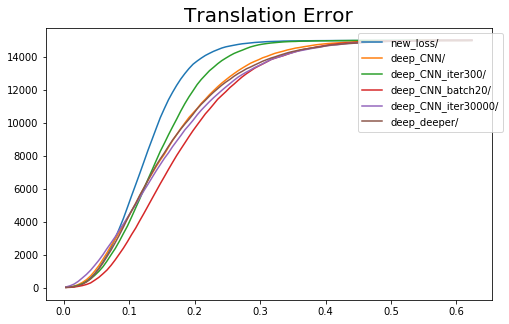

In [92]:
def trans_error(x1, x2):
    return np.linalg.norm(x1 - x2, axis=1)

cumsum = []
for i in range(len(setting_selector)):
    base, c = cumulative(trans_error(x_ground[i], x_pre[i]), 100)
    cumsum.append(c)

plot_graph('Translation Error', base[:-1], cumsum, [settings[i] for i in setting_selector])

### Rate error -angle

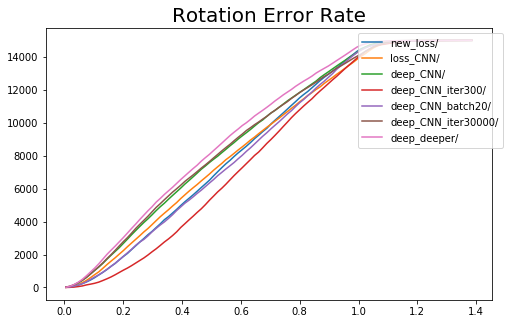

In [87]:
no_rotation = np.zeros((len(x_ground[0]),4))
no_rotation[:,0] = 1

cumsum = []
for i in range(len(setting_selector)):
    d1 = angle_error(no_rotation, quat_norm(q_ground[i]))
    d2 = angle_error(quat_norm(q_pre[i]), quat_norm(q_ground[i]))
    base, c = cumulative(d2/d1, 100)
    cumsum.append(c)

plot_graph('Rotation Error Rate', base[:-1], cumsum, [settings[i] for i in setting_selector])

### Rate error -translation

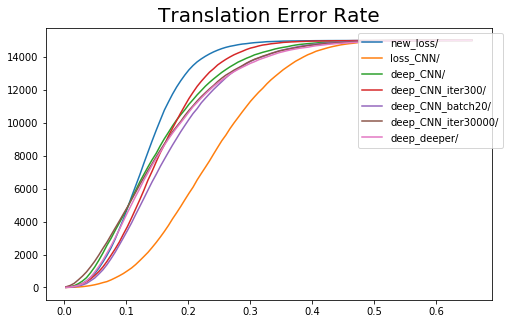

In [88]:
cumsum = []
for i in range(len(setting_selector)):
    base, c = cumulative(trans_error(x_ground[i], x_pre[i])/np.linalg.norm(x_ground[i], axis=1), 100)
    cumsum.append(c)

plot_graph('Translation Error Rate', base[:-1], cumsum, [settings[i] for i in setting_selector])

### Error By Category

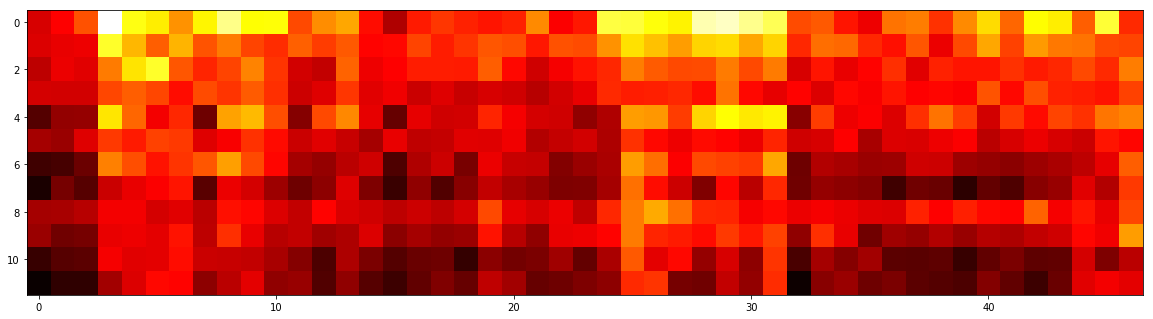

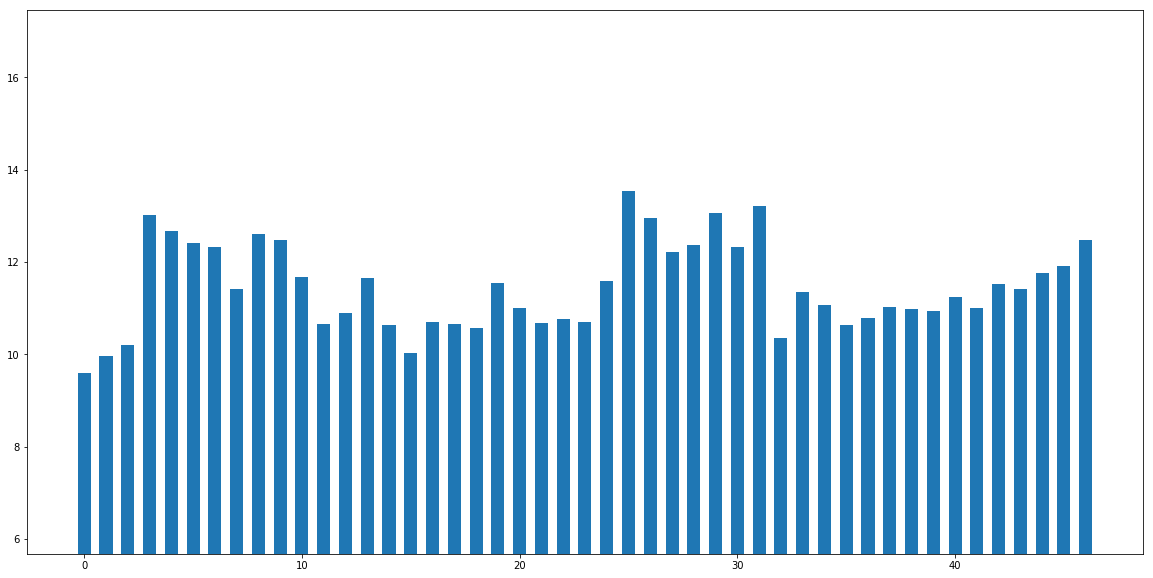

In [20]:
categ = np.squeeze(cate[0])
uniq = np.sort(np.unique(categ))
error = np.zeros((len(setting_selector), len(uniq)))
count = np.zeros((len(setting_selector), len(uniq)))
for i in range(len(setting_selector)):
    categ = np.squeeze(cate[i])
    uniq = np.sort(np.unique(categ))
    idx = list(range(len(uniq)))
    dic = dict(zip(uniq, idx))
    loss = single_loss(quat_norm(q_pre[i]), q_ground[i])
    for n in range(len(categ)):
        error[i, dic[categ[n]]] += loss[n]
        count[i, dic[categ[n]]] += 1

error = error/count
plt.figure(figsize=(20,10))
plt.imshow(error, cmap='hot', interpolation='nearest')
plt.show()
plt.figure(figsize=(20,10))
error = np.sum(error, axis=0)
minmax = np.max(error) - np.min(error)
axes = plt.gca()
axes.set_ylim([np.min(error) - minmax, np.max(error) + minmax])
plt.bar(idx, error, width = 0.6)
plt.show()

## Intermediate output - Feature Map

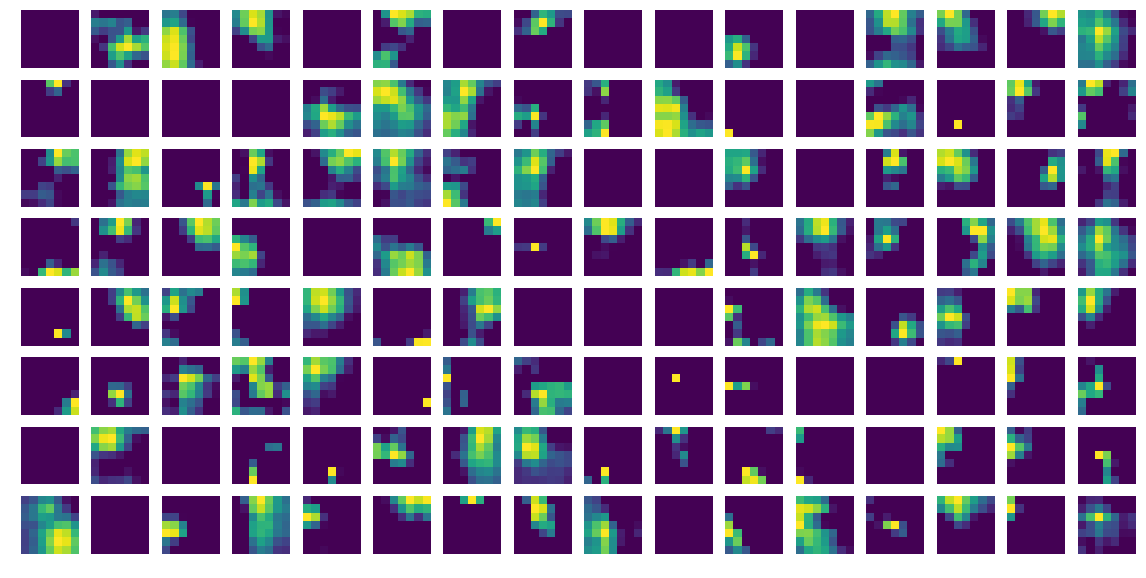

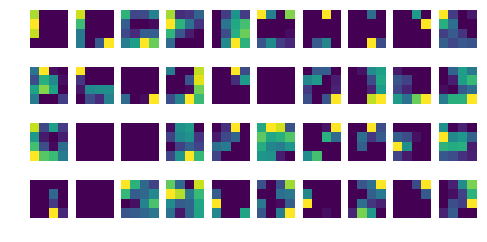

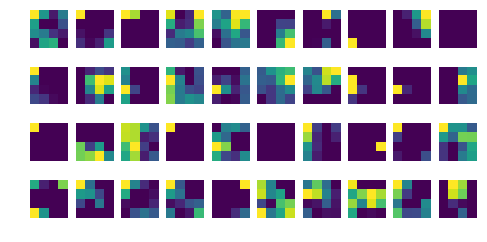

In [35]:
feat = np.load('feature.npz')
main = np.squeeze(feat['main'])
plt.figure(figsize=(20,10))
for i in range(128):
    plt.subplot(8, 16,i+1)
    plt.imshow(main[:,:,i])
    plt.axis('off')
plt.show()

main = np.squeeze(feat['aux1'])
plt.figure(figsize=(8,4))
for i in range(40):
    plt.subplot(4, 10,i+1)
    plt.imshow(main[:,:,i])
    plt.axis('off')
plt.show()

main = np.squeeze(feat['aux2'])
plt.figure(figsize=(8,4))
for i in range(40):
    plt.subplot(4, 10,i+1)
    plt.imshow(main[:,:,i])
    plt.axis('off')
plt.show()